<a href="https://colab.research.google.com/github/sydney-machine-learning/COVID19_sentinentanalysissocialmedia/blob/main/EDA%20%2B%20Preprocessing%20%2B%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **EDA**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
import re
import unicodedata
import nltk
import csv
from textblob import TextBlob
from nltk.corpus import stopwords
!pip install demoji
nltk.download('all')
import demoji

In [2]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchtext
from torchtext import data

import warnings
warnings.filterwarnings('ignore')
import operator

from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

In [3]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

Cloning into 'COVID19_sentinentanalysissocialmedia'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 194 (delta 9), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (194/194), 58.47 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [4]:
demoji.download_codes()

... OK (Got response in 0.39 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [5]:
senwave = pd.read_csv("/content/drive/My Drive/Covid 19 India/labeledEn.csv")
print("Length of Senwave Dataset = {}".format(len(senwave)))

Length of Senwave Dataset = 10000


In [6]:
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,Btw producers send me beats I’m working on mus...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,"Dear soccer,\nI really miss you ,please come b...",0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus! tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,When Xavier Wulf does an Attack on Titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,Mouthwash is hand san for your mouth and I don...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,@Sandykikimunch2 @Thomas1774Paine Yes all of t...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,Update I destroyed the tire 😔 honestly if I ge...,0,0,0,1,0,1,0,0,0,0,0


Text(0.5, 0, 'Count')

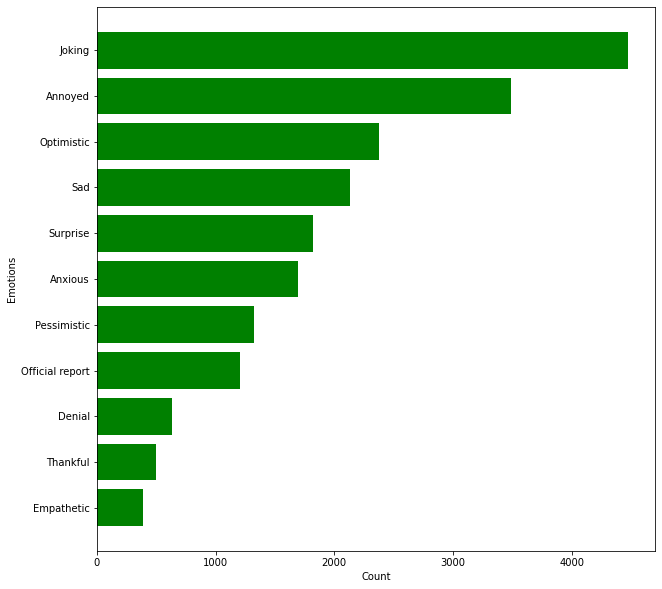

In [7]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
pairs = []

for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))

pairs = sorted(pairs, key = lambda x : x[1], reverse = False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [8]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  CORONAVIRUS IS OVER !!!

sike it’s April fools.

we’re still going through this bullshit.
Optimistic :  0
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  0
Annoyed :  0
Denial :  0
Official report :  0
Surprise :  0
Joking :  1


In [9]:
only_emotes = senwave[emotions]

In [10]:
only_emotes

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,0,0,0,0,0,0,0,0,1
9996,1,1,0,0,1,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,1,0
9998,1,0,0,1,0,0,0,0,0,0,1


In [11]:
only_emotes.iloc[0].tolist()

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [12]:
emote_array = np.zeros((11, 11))
e2i = {
    'Optimistic' : 0, 'Thankful' : 1, 'Empathetic' : 2, 'Pessimistic' : 3, 'Anxious' : 4, 'Sad' : 5, 'Annoyed' : 6, 'Denial' : 7, 'Official report' : 8,
    'Surprise' : 9, 'Joking' : 10
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(11):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 11):
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [13]:
emote_df = pd.DataFrame(emote_array, columns = emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,2373,235,171,226,246,291,379,72,156,387,982
1,235,498,28,15,41,29,67,14,70,98,92
2,171,28,389,18,50,71,41,7,7,24,63
3,226,15,18,1325,268,272,420,90,62,264,554
4,246,41,50,268,1695,360,452,95,138,357,510
5,291,29,71,272,360,2133,723,54,186,299,747
6,379,67,41,420,452,723,3492,261,122,536,1235
7,72,14,7,90,95,54,261,631,51,201,184
8,156,70,7,62,138,186,122,51,1207,284,95
9,387,98,24,264,357,299,536,201,284,1820,612


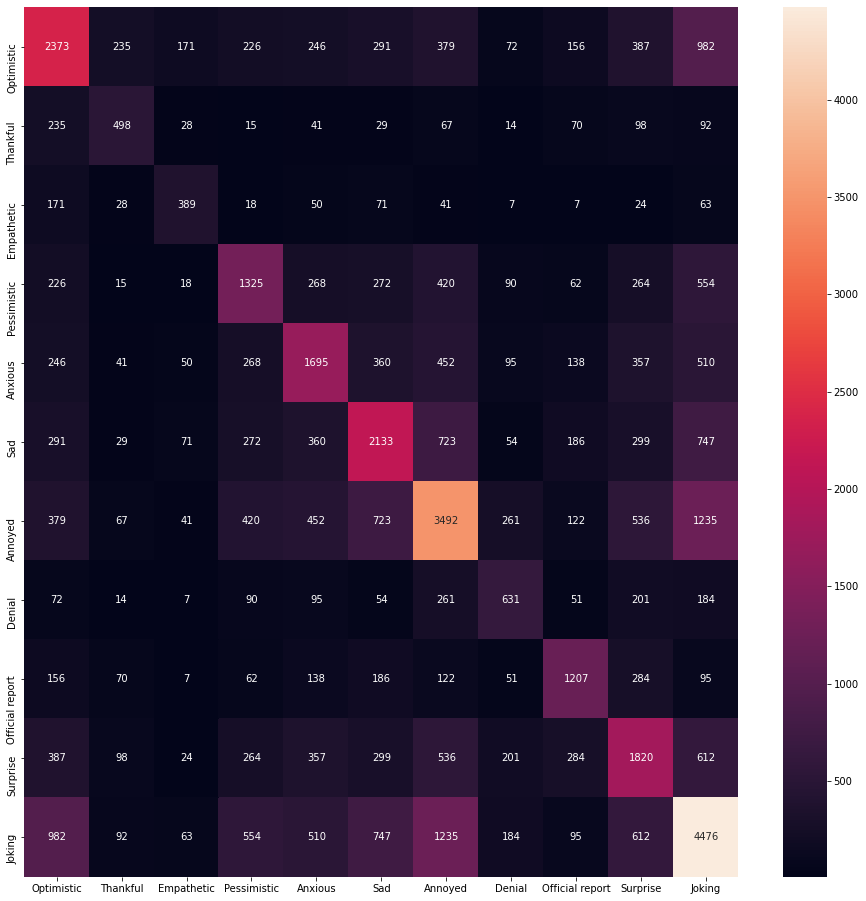

In [14]:
fig = plt.figure(figsize = (16,16))
sns.heatmap(emote_df, annot = True, xticklabels = emote_df.columns, yticklabels = emote_df.columns, fmt = 'g')

Inferences:
*   We see that around 1000 people who were being optimistic also had a joke emotion attached to their tweet.
* Around 390 of the people who were being positive also had a surprise attached to their tweet. It could be probably because of some good news they weren't expecting.
* Pessimistic tweets usually were of joking nature or were displaying their annoyance.
*   When people were being thankful, it was usually towards the Government or God or People in general and therefore it made them optimistic for the future (about 240)
* About 1200 of the people who were annoyed were also joking. Displaying your annoyance through jokes never goes out of style.
* About 780 of the 2100 tweets which were sad were jokes, i.e. people were trying to drown their sadness through laughter.


**WORD CLOUDs**

**Optimism**

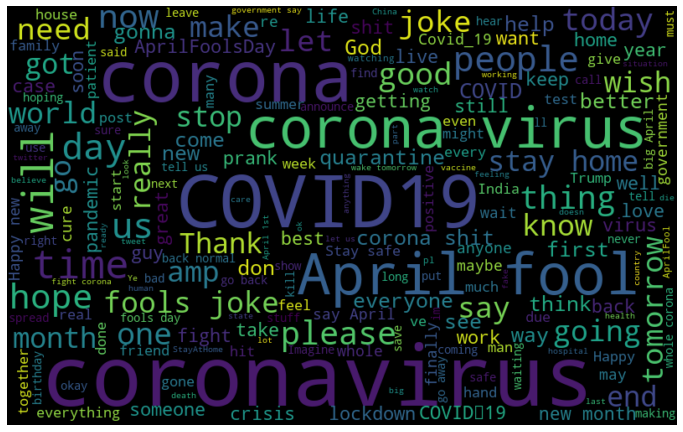

In [15]:
optimisticWords = " ".join([word for word in senwave['Tweet'][senwave['Optimistic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(optimisticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thankful**

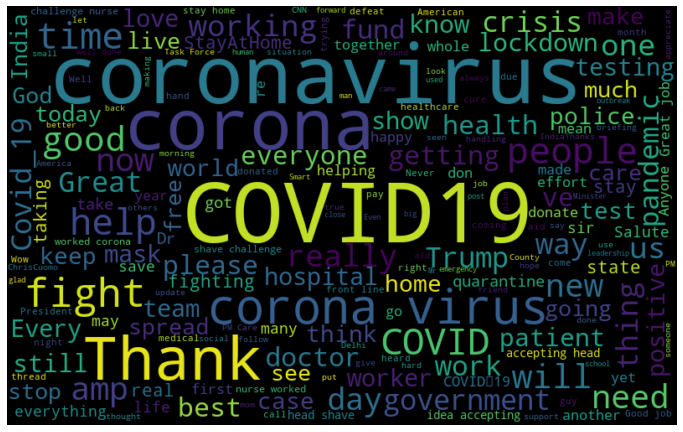

In [16]:
thankfulWords = " ".join([word for word in senwave['Tweet'][senwave['Thankful'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(thankfulWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Empathy**

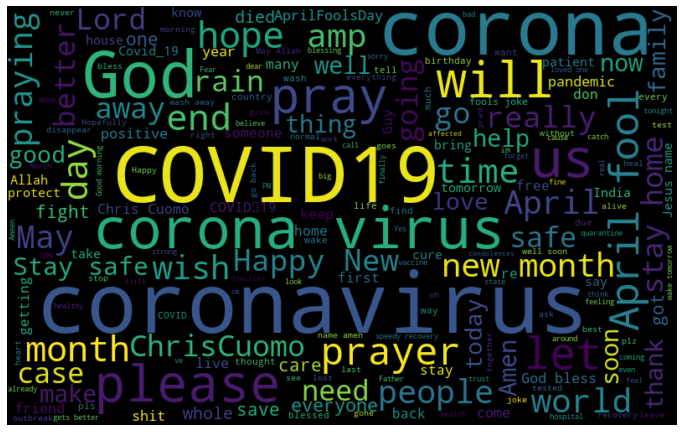

In [17]:
empatheticWords = " ".join([word for word in senwave['Tweet'][senwave['Empathetic'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(empatheticWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Anxiety**

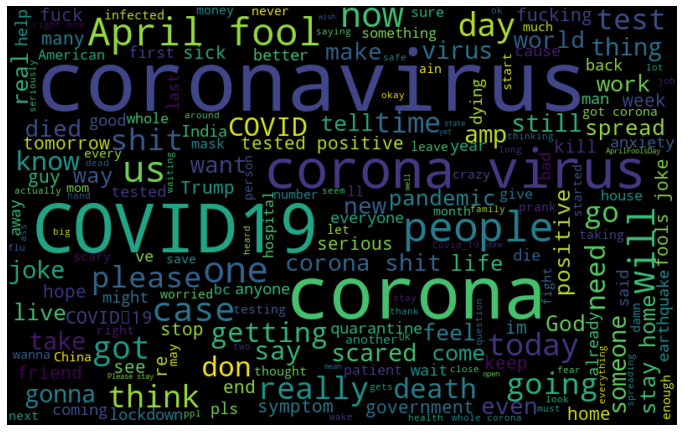

In [18]:
anxiousWords = " ".join([word for word in senwave['Tweet'][senwave['Anxious'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(anxiousWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Sad**

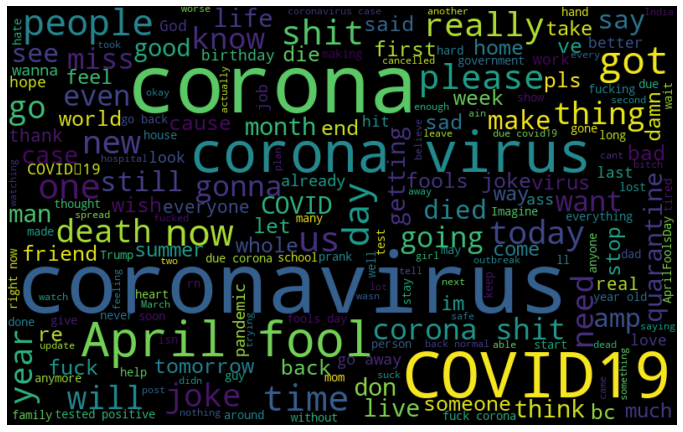

In [19]:
sadWords = " ".join([word for word in senwave['Tweet'][senwave['Sad'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(sadWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Official Report**

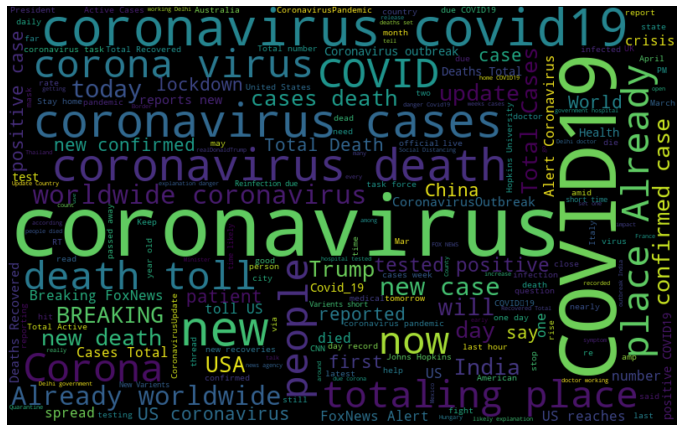

In [20]:
ORWords = " ".join([word for word in senwave['Tweet'][senwave['Official report'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(ORWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Joking**

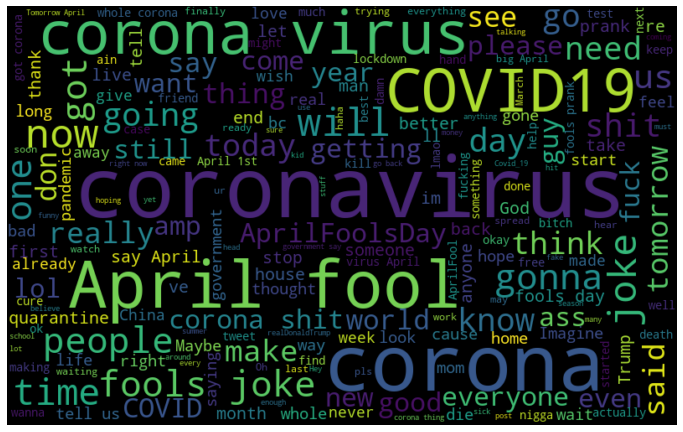

In [21]:
jokeWords = " ".join([word for word in senwave['Tweet'][senwave['Joking'] == 1]])
wc = WordCloud(width = 800, height = 500, max_font_size = 100).generate(jokeWords)
plt.figure(figsize = (12, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Cleaning followed by Unigram and Bigram analysis**

In [22]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [23]:
words = clean(''.join(str(senwave['Tweet'].tolist())))

In [24]:
words[:20]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'ma',
 'cheer',
 'anyone',
 'tell',
 'took',
 'flu',
 'shot',
 'last',
 'year',
 'give',
 'positive',
 'result']

**N-gram analysis**

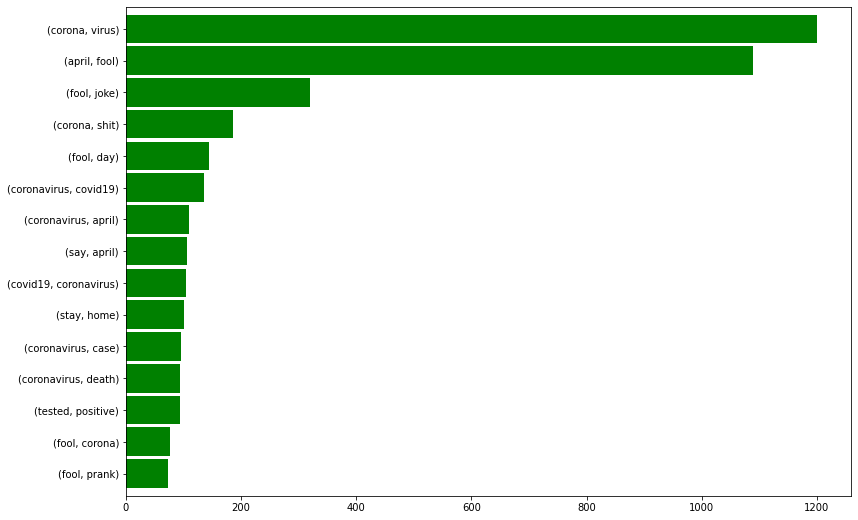

In [25]:
bigrams_series = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:15]
trigrams_series = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:15]

bigrams_series.sort_values().plot.barh(color = 'green', width = 0.9, figsize = (13, 9))

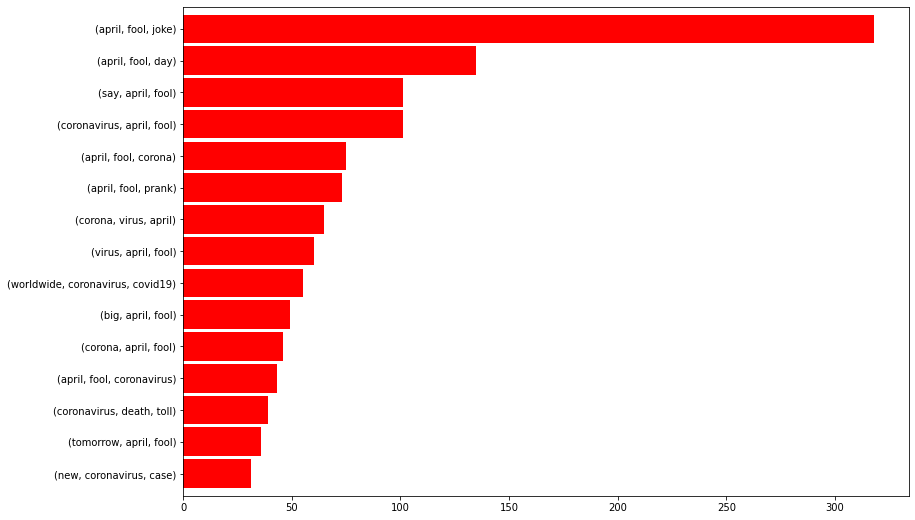

In [26]:
trigrams_series.sort_values().plot.barh(color = 'red', width = 0.9, figsize = (13, 9))

## **Preprocessing**

In [27]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [28]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [29]:
from COVID19_sentinentanalysissocialmedia.preprocessing.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [30]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head(10)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
0,1.245140e+18,a glass of wine keeps the corona away drake ...,1,0,0,0,0,0,0,0,0,0,1
1,1.245140e+18,can anyone tell me if you took the flu shot la...,0,0,0,0,1,0,0,0,0,1,0
2,1.245140e+18,by the way producers send me beats i am workin...,1,0,0,0,0,0,0,0,0,0,1
3,1.245140e+18,when someone you know apart of your family d...,0,0,0,0,0,1,0,0,0,0,0
4,1.245140e+18,dear soccer \ni really miss you please come b...,0,0,0,0,0,1,1,0,0,0,0
5,1.245140e+18,new home remedy to treat coronavirus tested b...,1,0,0,0,0,0,0,1,0,0,1
6,1.245140e+18,when xavier wulf does an attack on titan tape ...,0,0,0,0,0,0,0,0,0,0,1
7,1.245140e+18,mouthwash is hand san for your mouth and i do ...,0,0,0,0,0,1,0,0,0,1,1
8,1.245140e+18,yes all of them i̇n france 1 000 christian...,0,0,0,0,0,0,1,0,1,1,0
9,1.245140e+18,update i destroyed the tire pensive face hones...,0,0,0,1,0,1,0,0,0,0,0


In [31]:
def check_coverage(vocab, embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:
            oov[word] = vocab[word]
            i += vocab[word]
            pass
        
    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key = operator.itemgetter(1))[::-1]

    return sorted_x

def build_vocab(sentences, verbose = True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except:
                vocab[word] = 1
    return vocab

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def load_embeddings(path):
    with open(path, encoding = "utf-8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)


def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

In [32]:
GLOVE_EMBEDDING_FILE = '/content/drive/MyDrive/Covid 19 India/glove.840B.300d.txt'
glove_embeddings = load_embeddings(GLOVE_EMBEDDING_FILE)
print(f'loaded {len(glove_embeddings)} word vectors ')

loaded 2196007 word vectors 


In [37]:
vocab = build_vocab(list(senwave['Tweet'].apply(lambda x : x.split())))
oov = check_coverage(vocab, glove_embeddings)
oov[:10]


Found embeddings for 82.88% of vocab
Found embeddings for  98.31% of all text


[('coronavirusngr', 6),
 ('234radio', 6),
 ('‘s', 6),
 ('coronavirusiot', 6),
 ('2007218893', 5),
 ('b’s', 5),
 ('orkfromhome', 5),
 ('mom’s', 5),
 ('“my', 5),
 ('uhan', 5)]

In [38]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

## **Building the model followed by training & testing**

In [39]:
from sklearn.model_selection import train_test_split
sen_train, sen_test = train_test_split(senwave, train_size = 0.9, random_state = 1024)

sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [40]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Surprise,Joking
560,1.245140e+18,minister for agriculture mahendra reddy to hol...,0,0,0,0,0,0,0,0,1,0,0


In [41]:
import spacy
spacy_en = spacy.load('en')

def tokenizer(tweet):
    tweet = re.sub(r'[\n]', ' ', tweet)
    return [tok.text for tok in spacy_en.tokenizer(tweet)]

TWEET = data.Field(sequential = True, lower = True, tokenize = tokenizer)
LABEL = data.Field(sequential = False, use_vocab = False)

dataFields = [("ID", None), ("Tweet", TWEET), ("Optimistic", LABEL), ("Thankful", LABEL),
              ("Empathetic", LABEL), ("Pessimistic", LABEL), ("Anxious", LABEL), ("Sad", LABEL),
              ("Annoyed", LABEL), ("Denial", LABEL), ("Official report", LABEL),
              ("Surprise", LABEL), ("Joking", LABEL)]

train_dataset, test_dataset = data.TabularDataset.splits(
    path = '/content/', train = 'train.csv', test = 'test.csv', format = 'csv', fields = dataFields, skip_header = True
    )

In [42]:
print("Number of training samples : {}\n Number of testing samples : {}".format(len(train_dataset), len(test_dataset)))

Number of training samples : 9000
 Number of testing samples : 1000


In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
TWEET.build_vocab(train_dataset, vectors = 'glove.840B.300d')

.vector_cache/glove.840B.300d.zip: 2.18GB [16:57, 2.14MB/s]                            
100%|█████████▉| 2195820/2196017 [05:10<00:00, 7361.18it/s]

**Hyperparameters to be considered**
*  Learning Rate
*  Hidden Dimension of LSTM
*  Dropout Probability
*  Threshold



In [44]:
vocab = TWEET.vocab
BATCH_SIZE = 32
n_label = 11
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iter, test_iter = data.BucketIterator.splits(datasets = (train_dataset, test_dataset),
                                                   batch_size = BATCH_SIZE,
                                                   sort_key = lambda x : len(x.Tweet),
                                                   sort_within_batch = False,
                                                   repeat = False,
                                                   device = device)

In [45]:
np.random.seed(1024)
for i in range(TWEET.vocab.vectors.shape[0]):
    vec = TWEET.vocab.vectors[i]
    if torch.sum(vec).item() == 0:
        a = np.random.uniform(-0.25, 0.25, 300)
        TWEET.vocab.vectors[i] = torch.from_numpy(a)

In [46]:
batch = next(train_iter.__iter__()); batch


[torchtext.data.batch.Batch of size 32]
	[.Tweet]:[torch.cuda.LongTensor of size 34x32 (GPU 0)]
	[.Optimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Thankful]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Empathetic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Pessimistic]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Anxious]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Sad]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Annoyed]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Denial]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Official report]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Surprise]:[torch.cuda.LongTensor of size 32 (GPU 0)]
	[.Joking]:[torch.cuda.LongTensor of size 32 (GPU 0)]

In [47]:
#idea taken from http://mlexplained.com/2018/02/08/a-comprehensive-tutorial-to-torchtext/
class BatchWrapper():
    def __init__(self, dl, x_var, y_vars):
        self.dl = dl
        self.x_var = x_var
        self.y_vars = y_vars

    def __iter__(self):
        for batch in self.dl:
            x = getattr(batch, self.x_var)
            if self.y_vars is not None:
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y_vars], dim = 1).float()
            else:
                y = torch.zeros((1))
            yield(x, y)
    
    def __len__(self):
        return len(self.dl)

In [48]:
train_dl = BatchWrapper(train_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                              'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])
test_dl = BatchWrapper(test_iter, "Tweet", ['Optimistic', 'Thankful', 'Empathetic', 'Pessimistic', 
                                            'Anxious', 'Sad', 'Annoyed', 'Denial', 'Official report', 'Surprise', 'Joking'])

In [65]:
class CustomLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab, hidden_dim, output_dim, drop_prob, bidirectional = False):
        super().__init__()
        self.embeddings = nn.Embedding(len(vocab), embedding_dim)
        self.embeddings.weight.data.copy_(vocab.vectors)
        self.embeddings.weight.requires_grad = False
        self.drop_prob = drop_prob

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = bidirectional, batch_first = True, num_layers = 2)
        self.lin = nn.Linear(hidden_dim, 64)
        self.fc = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p = drop_prob)
    
    def forward(self, sentence):
        #sentence = [max_len, batch_size]

        embed = self.embeddings(torch.transpose(sentence, 0, 1))
        #embed = [batch_size, max_len, embedding_dim]
        
        if self.drop_prob:
            embed = self.dropout(embed)
        
        lstm_out, (hidden, cell) = self.lstm(embed)
        #hidden = [batch_size, max_len, hidden_dim]
        
        out = lstm_out[:,-1,:].squeeze()
        #out = [batch_size, hidden_dim]
        
        out = self.lin(out)
        #out = [batch_size, 64]

        outputs = self.fc(out)
        #outputs = [batch_size, output_dim]
        
        return outputs

In [66]:
def evaluation_metrics(actual_labels, pred_labels, threshold):
    int_pred_labels = pred_labels
    for i in range(len(pred_labels)):
        for j in range(11):
            if int_pred_labels[i][j] >= threshold: int_pred_labels[i][j] = 1
            else:
                int_pred_labels[i][j] = 0
    
    ham_loss = hamming_loss(actual_labels, int_pred_labels)
    jacc_score = jaccard_score(actual_labels, int_pred_labels, average = 'samples')
    lrap = label_ranking_average_precision_score(actual_labels, pred_labels)
    f1_macro = f1_score(actual_labels, int_pred_labels, average = 'macro')
    f1_micro = f1_score(actual_labels, int_pred_labels, average = 'micro')

    return ham_loss, jacc_score, lrap, f1_macro, f1_micro

In [67]:
def train(model, loss_fn, optimizer, n_epochs, train_dl, threshold):

    train_losses = []  
    hamming_losses = []
    jaccard_scores = []
    lraps = []  
    iter = 1

    for epoch in range(1, n_epochs+1):
        running_loss = 0.0
        pred_labels = []
        actual_labels = []
        model.train()
        for x, y in train_dl:
            #print(x.shape, y.shape)
            optimizer.zero_grad()

            preds = model(x)

            m = nn.Sigmoid()
            sig_preds = m(preds)
            
            for tens in sig_preds:
                pred_labels.append(tens.cpu().detach().numpy())
            for tens in y:
                actual_labels.append(tens.cpu().detach().numpy())

            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.shape[0]

        ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)
        hamming_losses.append(ham_loss)
        lraps.append(lrap)
        jaccard_scores.append(jacc_score)
        '''
        if iter % 5 == 0:
            print("Epoch: ", epoch)
            print("Binary Cross Entropy With Logits Loss: {:.4f}".format(epoch_loss))
            print("Hamming Loss : {:.4f}".format(ham_loss))
            print("Jaccard Score: {:.4f}".format(jacc_score))
            print("Label Ranking Average Precision Score: {:.4f}".format(lrap))
            print("F1 Macro Score: {:.4f}".format(f1_macro))
            print("F1 Micro Score: {:.4f}".format(f1_micro))
            print("\n")
        iter += 1
        '''
    return train_losses, hamming_losses, jaccard_scores, lraps, f1_macro, f1_micro

In [68]:
def test(model, loss_fn, test_dl, threshold):
    running_loss = 0.0
    pred_labels = []
    actual_labels = []
    model.eval()
    for x, y in test_dl:
        #print(x.shape, y.shape)

        preds = model(x)

        m = nn.Sigmoid()
        sig_preds = m(preds)
        
        for tens in sig_preds:
            pred_labels.append(tens.cpu().detach().numpy())
        for tens in y:
            actual_labels.append(tens.cpu().detach().numpy())

        loss = loss_fn(preds, y)

        running_loss += loss.item() * x.shape[0]

    ham_loss, jacc_score, lrap, f1_macro, f1_micro = evaluation_metrics(actual_labels, pred_labels, threshold)

    test_loss = running_loss / len(test_dataset)
    return test_loss, ham_loss, jacc_score, lrap, f1_macro, f1_micro

# **Experimentation with various combinations of the hyperparameters**

## Till 22-12-2020

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
dropouts = [True, False]

all_models = []
iter = 1
#number of iterations = 3*2*2 = 12 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for dropout in dropouts:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = dropout)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout = {}".format(learning_rate, hidden_dim, threshold, dropout))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

Iteration : 1
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout = True
Binary Cross Entropy With Logits Loss: 0.2243
Hamming Loss : 0.0980
Jaccard Score: 0.6457
Label Ranking Average Precision Score: 0.6859
F1 Macro Score: 0.6639
F1 Micro Score: 0.7220


TestBinary Cross Entropy With Logits Loss: 0.2692
Test Hamming Loss : 0.1750
Test Jaccard Score: 0.4025
Test Label Ranking Average Precision Score: 0.4796
Test F1 Macro Score: 0.4352
Test F1 Micro Score: 0.4882


----------------------------------------------------------------
Iteration : 2
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout = False
Binary Cross Entropy With Logits Loss: 0.0248
Hamming Loss : 0.0084
Jaccard Score: 0.9688
Label Ranking Average Precision Score: 0.9721
F1 Macro Score: 0.9698
F1 Micro Score: 0.9770


TestBinary Cross Entropy With Logits Loss: 0.7358
Test Hamming Loss : 0.1865
Test Jaccard Score: 0.3835
Test Label Ranking Average Precision Score: 0.4591
Test F1 Macr

## 23-12-2020
*  taking inference from the previous days, having a dropout in the LSTM layer has always lowered the overfitting. Hence we will be using dropout layers in all models today.
*  We shall experiment with the values of the dropout probability today

In [ ]:
learning_rates = [1e-3]
hidden_dims = [128, 256]
thresholds = [0.4, 0.45, 0.5]
drop_probs = [0.4, 0.5, 0.6, 0.7]

all_models = []
iter = 1
#number of iterations = 4*3*2 = 24 = number of models

for learning_rate in learning_rates:
    for hidden_dim in hidden_dims:
        for threshold in thresholds:
            for drop_prob in drop_probs:
                model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
                model = model.to(device)

                optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
                loss_fn = nn.BCEWithLogitsLoss()

                train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
                all_models.append(model)
                print("Iteration : {}".format(iter))
                print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
                print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
                print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
                print("Jaccard Score: {:.4f}".format(max(jacc_score)))
                print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
                print("F1 Macro Score: {:.4f}".format(f1_macro))
                print("F1 Micro Score: {:.4f}".format(f1_micro))
                print("\n")

                test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
                print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
                print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
                print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
                print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
                print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
                print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
                print("\n")
                print("----------------------------------------------------------------")
                iter += 1

Iteration : 1
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout Probability = 0.4
Binary Cross Entropy With Logits Loss: 0.1793
Hamming Loss : 0.0765
Jaccard Score: 0.7205
Label Ranking Average Precision Score: 0.7503
F1 Macro Score: 0.7465
F1 Micro Score: 0.7877


TestBinary Cross Entropy With Logits Loss: 0.3169
Test Hamming Loss : 0.1803
Test Jaccard Score: 0.4085
Test Label Ranking Average Precision Score: 0.4805
Test F1 Macro Score: 0.4341
Test F1 Micro Score: 0.4955


----------------------------------------------------------------
Iteration : 2
Learning Rate : 0.001, Hidden Dimension : 128, Threshold : 0.4, Dropout Probability = 0.5
Binary Cross Entropy With Logits Loss: 0.2085
Hamming Loss : 0.0896
Jaccard Score: 0.6749
Label Ranking Average Precision Score: 0.7113
F1 Macro Score: 0.6880
F1 Micro Score: 0.7472


TestBinary Cross Entropy With Logits Loss: 0.2869
Test Hamming Loss : 0.1801
Test Jaccard Score: 0.4089
Test Label Ranking Average Precision Score

# Some inferences
*  Best Test BCE with logits loss at Iteration 12<br>
*  Best Test Hamming Loss at Iteration 12<br>
*  Best Test Jaccard Score at Iteration 3 & 16<br>
*  Best Test LRAP Score at Iteration 11<br>
*  Best Test F1 Macro Score at Iteration 16<br>
*  Best Test F1 Micro Score at Iteration 3<br>
<br> <br>
*  This indicates that we need only consider hyperparams corresponding to iterations 3, 11, 12 and 16



 **Hyperparameters to be considered for the final steps**:

*   Learning Rate: 0.001
*   Hidden Dimension: 3, 11, 12 = 128 & 16 = 256
*   Threshold: 3 & 16 = 0.4, 11 & 12 = 0.5
*   Dropout Probability: 3 & 11 = 0.6, 12 & 16 = 0.7

## Final evaluation using narrowed down hyperparameters
26-12-2020

In [70]:
%%time
learning_rate = 1e-3
hidden_dim = 128
threshold = 0.5
drop_prob = 0.65

all_bce_losses = []
all_hamm_losses = []
all_jacc_scores = []
all_lraps = []
all_f1_macro = []
all_f1_micro = []
all_models = []

for exp in range(1, 11):

    print("Experiment {}".format(exp), '\n\n')

    model = CustomLSTM(embedding_dim = vocab.vectors.shape[1], vocab = vocab, hidden_dim = hidden_dim, output_dim = 11, drop_prob = drop_prob)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()

    train_loss, hamm_loss, jacc_score, lrap, f1_macro, f1_micro = train(model, loss_fn, optimizer, 50, train_dl, threshold)
    torch.save(model, 'model{}.pth'.format(exp))
    '''
    print("Learning Rate : {}, Hidden Dimension : {}, Threshold : {}, Dropout Probability = {}".format(learning_rate, hidden_dim, threshold, drop_prob))
    print("Binary Cross Entropy With Logits Loss: {:.4f}".format(min(train_loss)))
    print("Hamming Loss : {:.4f}".format(min(hamm_loss)))
    print("Jaccard Score: {:.4f}".format(max(jacc_score)))
    print("Label Ranking Average Precision Score: {:.4f}".format(max(lrap)))
    print("F1 Macro Score: {:.4f}".format(f1_macro))
    print("F1 Micro Score: {:.4f}".format(f1_micro))
    print("\n")
    '''

    test_loss, test_hamm_loss, test_jacc_score, test_lrap, test_f1_macro, test_f1_micro = test(model, loss_fn, test_dl, threshold)
    all_bce_losses.append(test_loss)
    all_hamm_losses.append(test_hamm_loss)
    all_jacc_scores.append(test_jacc_score)
    all_lraps.append(test_lrap)
    all_f1_macro.append(test_f1_macro)
    all_f1_micro.append(test_f1_micro)


    print("TestBinary Cross Entropy With Logits Loss: {:.4f}".format(test_loss))
    print("Test Hamming Loss : {:.4f}".format(test_hamm_loss))
    print("Test Jaccard Score: {:.4f}".format(test_jacc_score))
    print("Test Label Ranking Average Precision Score: {:.4f}".format(test_lrap))
    print("Test F1 Macro Score: {:.4f}".format(test_f1_macro))
    print("Test F1 Micro Score: {:.4f}".format(test_f1_micro))
    print("\n")

Experiment 1 


TestBinary Cross Entropy With Logits Loss: 0.2604
Test Hamming Loss : 0.1605
Test Jaccard Score: 0.4012
Test Label Ranking Average Precision Score: 0.4961
Test F1 Macro Score: 0.4334
Test F1 Micro Score: 0.4804


Experiment 2 


TestBinary Cross Entropy With Logits Loss: 0.2507
Test Hamming Loss : 0.1594
Test Jaccard Score: 0.4120
Test Label Ranking Average Precision Score: 0.5042
Test F1 Macro Score: 0.4276
Test F1 Micro Score: 0.4888


Experiment 3 


TestBinary Cross Entropy With Logits Loss: 0.2519
Test Hamming Loss : 0.1545
Test Jaccard Score: 0.4255
Test Label Ranking Average Precision Score: 0.5207
Test F1 Macro Score: 0.4378
Test F1 Micro Score: 0.4939


Experiment 4 


TestBinary Cross Entropy With Logits Loss: 0.2712
Test Hamming Loss : 0.1623
Test Jaccard Score: 0.4084
Test Label Ranking Average Precision Score: 0.4984
Test F1 Macro Score: 0.4265
Test F1 Micro Score: 0.4878


Experiment 5 


TestBinary Cross Entropy With Logits Loss: 0.2541
Test Hamming Loss 

In [71]:
print("Average Binary Cross Entropy With Logits Loss: {:.4f}".format(sum(all_bce_losses)/10))
print("Average Hamming Loss : {:.4f}".format(sum(all_hamm_losses)/10))
print("Average Jaccard Score: {:.4f}".format(sum(all_jacc_scores)/10))
print("Average Label Ranking Average Precision Score: {:.4f}".format(sum(all_lraps)/10))
print("Average F1 Macro Score: {:.4f}".format(sum(all_f1_macro)/10))
print("Average F1 Micro Score: {:.4f}".format(sum(all_f1_micro)/10))

Average Binary Cross Entropy With Logits Loss: 0.2552
Average Hamming Loss : 0.1569
Average Jaccard Score: 0.4184
Average Label Ranking Average Precision Score: 0.5111
Average F1 Macro Score: 0.4308
Average F1 Micro Score: 0.4934


**Model 7 performed the best, so I downloaded the weights**